In [1]:
import tensorflow as tf
import fasttext
import numpy as np
import pickle
import jieba
import pandas as pd
import keras
from keras.layers import Input,Dense,Conv1D,MaxPooling1D,Flatten,Dropout,concatenate,Bidirectional,GRU,TimeDistributed
from keras.utils import to_categorical
import pickle
from keras.models import Model
from keras.engine.topology import Layer
from keras import initializers
from keras import backend as K
import matplotlib.pyplot as plt 
from tensorflow.contrib.rnn import *


/home/weiyu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/weiyu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/weiyu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/weiyu/anaconda3/envs/tensorflow

# 加载数据

In [2]:
#加载数据
with open("./data/data_input.pkl", "rb") as f:
    text_train, label_train, text_test, label_test, label_names = pickle.load(f)

In [3]:
#加载停用词
stopwords=pd.read_csv("./data/stopwords.txt",index_col=False,quoting=3,sep="\t",names=['stopword'], encoding='utf-8')
stopwords=stopwords['stopword'].values

# 数据预处理

In [4]:
def text_to_tokens(line):
    sentences = line.split("。")
    tokens=[]
    for x in sentences[:10]:
        words = jieba.lcut(x)
        tokens.append(np.array([x for x in words if x not in stopwords]))
    return tokens

In [5]:
x_train_tokens = np.array([text_to_tokens(x) for x in text_train])
x_test_tokens = np.array([text_to_tokens(x) for x in text_test])

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Dumping model to file cache /tmp/jieba.cache
Dump cache file failed.
Traceback (most recent call last):
  File "/home/weiyu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/jieba/__init__.py", line 154, in initialize
    _replace_file(fpath, cache_file)
PermissionError: [Errno 1] Operation not permitted: '/tmp/tmprltve71j' -> '/tmp/jieba.cache'
Loading model cost 1.004 seconds.
Prefix dict has been built successfully.


In [6]:
x_train_tokens[0][1][1]

'连续'

In [7]:
model=fasttext.load_model("./model/model_fasttext.bin")

In [8]:
sequence_count=10
sequence_len=10
embedding_size=300
#处理成定长
def get_embedding(line):
    word_vec=np.zeros([sequence_count,sequence_len,embedding_size],dtype="float")
    for i in range(min(sequence_count,len(line))):
        for j in range(sequence_len):
            if(j<len(line[i])):
                word_vec[i][j]=model[line[i][j]]
            else:
                word_vec[i][j]=model["blank"]
    return word_vec           

In [9]:
x_train = np.array([get_embedding(x) for x in x_train_tokens])
x_test = np.array([get_embedding(x) for x in x_test_tokens])

In [10]:
x_train.shape

(5734, 10, 10, 300)

In [11]:
y_train = to_categorical(label_train)
y_test = to_categorical(label_test)

# 模型训练

In [12]:
#  使用gpu
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

# 设置定量的GPU使用量
config = tf.ConfigProto()
session = tf.Session(config=config)

# 设置最少显存
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [13]:
class AttLayer(Layer):
    def __init__(self, attention_dim, **kwargs):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(AttLayer, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim, )))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(AttLayer, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return mask

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)

        ait = K.exp(ait)

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        ait = K.expand_dims(ait)
        weighted_input = x * ait
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        config = {
            'attention_dim': self.attention_dim
        }
        base_config = super(AttLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [14]:
#HAN
input_layer = Input(shape=(sequence_len,embedding_size), dtype='float')
l_lstm = Bidirectional(GRU(10, return_sequences=True))(input_layer)
l_att = AttLayer(10)(l_lstm)
sentEncoder = Model(input_layer, l_att)
review_input = Input(shape=(sequence_count,sequence_len,embedding_size), dtype='float')
review_encoder = TimeDistributed(sentEncoder)(review_input)
l_lstm_sent = Bidirectional(GRU(10, return_sequences=True))(review_encoder)
l_att_sent = AttLayer(10)(l_lstm_sent)
preds = Dense(len(label_names), activation='softmax')(l_att_sent)
model = Model(review_input, preds)

In [15]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(x_train, y_train, batch_size=32, epochs=20,validation_split=0.1)

Train on 5160 samples, validate on 574 samples
Epoch 1/20
5160/5160 [==============================] - 7s 1ms/step - loss: 3.3107 - acc: 0.1876 - val_loss: 2.8132 - val_acc: 0.2962
Epoch 2/20
5160/5160 [==============================] - 5s 947us/step - loss: 2.5775 - acc: 0.3599 - val_loss: 2.3468 - val_acc: 0.3833
Epoch 3/20
5160/5160 [==============================] - 5s 975us/step - loss: 2.2451 - acc: 0.4171 - val_loss: 2.1192 - val_acc: 0.4355
Epoch 4/20
5160/5160 [==============================] - 5s 967us/step - loss: 2.0456 - acc: 0.4527 - val_loss: 1.9791 - val_acc: 0.4774
Epoch 5/20
5160/5160 [==============================] - 5s 953us/step - loss: 1.8980 - acc: 0.4886 - val_loss: 1.8840 - val_acc: 0.4965
Epoch 6/20
5160/5160 [==============================] - 5s 997us/step - loss: 1.7846 - acc: 0.5132 - val_loss: 1.8023 - val_acc: 0.5000
Epoch 7/20
5160/5160 [==============================] - 5s 997us/step - loss: 1.6811 - acc: 0.5320 - val_loss: 1.7253 - val_acc: 0.5192
Epo

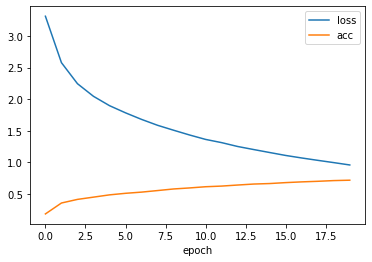

In [16]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["acc"],label="acc")
plt.xlabel('epoch')
plt.legend()

# 测试

In [17]:
result = model.predict(x_test)
y_predict = np.argmax(result, axis=1) 
# y_predict = list(map(str, result_labels))
# print(set(label_test)-set(y_predict))
from sklearn.metrics import classification_report
print(classification_report(y_pred= y_predict, y_true=label_test))

              precision    recall  f1-score   support

           0       0.54      0.81      0.65       254
           1       0.65      0.69      0.67       374
           2       0.35      0.51      0.42       310
           3       0.34      0.44      0.38       280
           4       0.55      0.61      0.58       276
           5       0.60      0.61      0.61       175
           6       0.50      0.55      0.52       159
           7       0.39      0.45      0.42       190
           8       0.26      0.09      0.14       164
           9       0.26      0.19      0.22       113
          10       0.68      0.77      0.72       145
          11       0.46      0.74      0.57        47
          12       0.15      0.18      0.16        28
          13       0.49      0.51      0.50        83
          14       0.00      0.00      0.00        60
          15       0.00      0.00      0.00        24
          16       0.64      0.79      0.71        85
          17       0.32    

/home/weiyu/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
